In [2]:
# 1) Install dependencies (uncomment if needed)
# !pip install statsmodels==0.14.0 --quiet

# 2) Imports
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from google.colab import files

# 3) Upload CSV (uses Colab UI - you'll be prompted to choose the file)
print("Upload your CSV (World_Series_Combined_Summary__2017_2024_.csv).")
uploaded = files.upload()  # select your CSV file when prompted

# Pick the uploaded file (assumes only one)
fn = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[fn]))

# Quick sanity check
print("\nDataset preview:")
print(df.head())
print("\nSummary counts by Year and HR_diff:")
print(df.groupby("Year").size())
print(df["HR_diff"].value_counts().sort_index())

Upload your CSV (World_Series_Combined_Summary__2017_2024_.csv).


Saving World_Series_Combined_Summary__2017_2024_.csv to World_Series_Combined_Summary__2017_2024_ (2).csv

Dataset preview:
   Year  Game     Team Opponent  Team_R  Opp_R  Team_HR  Opp_HR  HR_diff  Win
0  2017     1  Dodgers   Astros       3      1        2       1        1    1
1  2017     1   Astros  Dodgers       1      3        1       2       -1    0
2  2017     2  Dodgers   Astros       6      7        5       4        1    0
3  2017     2   Astros  Dodgers       7      6        4       5       -1    1
4  2017     3   Astros  Dodgers       5      3        2       4       -2    1

Summary counts by Year and HR_diff:
Year
2017    14
2018    10
2020    12
2024    10
dtype: int64
HR_diff
-3     4
-2     4
-1     9
 0    12
 1     9
 2     4
 3     4
Name: count, dtype: int64


In [5]:
# 4) Prepare data
# Ensure numeric types
df["HR_diff"] = pd.to_numeric(df["HR_diff"], errors="coerce")
df["Win"] = pd.to_numeric(df["Win"], errors="coerce")
# Observed win rate by HR_diff (for hero visual scatter)
win_rate = df.groupby("HR_diff", as_index=False)["Win"].agg(["mean","count"]).reset_index()
win_rate = win_rate[["HR_diff","mean","count"]]
win_rate.columns = ["HR_diff","Win_Rate","N"]

In [18]:

# 5) Logistic regression (Win ~ HR_diff)
X = sm.add_constant(df["HR_diff"])
y = df["Win"]
logit = sm.Logit(y, X).fit(disp=False)  # disp=False hides verbose output
print("\nLogistic regression summary (abridged):")
print(logit.summary2().tables[1])  # coefficient table

coef = logit.params["HR_diff"]
odds_ratio = np.exp(coef)
# percent change in odds per +1 HR_diff
pct_odds_change = (odds_ratio - 1) * 100
p_value = logit.pvalues["HR_diff"]

print(f"\nKey result: coef(HR_diff) = {coef:.3f}")
print(f"Odds ratio per +1 HR_diff = {odds_ratio:.3f}  -> ~{pct_odds_change:.1f}% change in odds (p = {p_value:.3g})")


Logistic regression summary (abridged):
                Coef.  Std.Err.             z     P>|z|    [0.025    0.975]
const    4.554750e-17  0.321977  1.414618e-16  1.000000 -0.631064  0.631064
HR_diff  5.728619e-01  0.227678  2.516109e+00  0.011866  0.126622  1.019102

Key result: coef(HR_diff) = 0.573
Odds ratio per +1 HR_diff = 1.773  -> ~77.3% change in odds (p = 0.0119)



Saved hero visual to: ws_hrdiff_winprob_hero.png


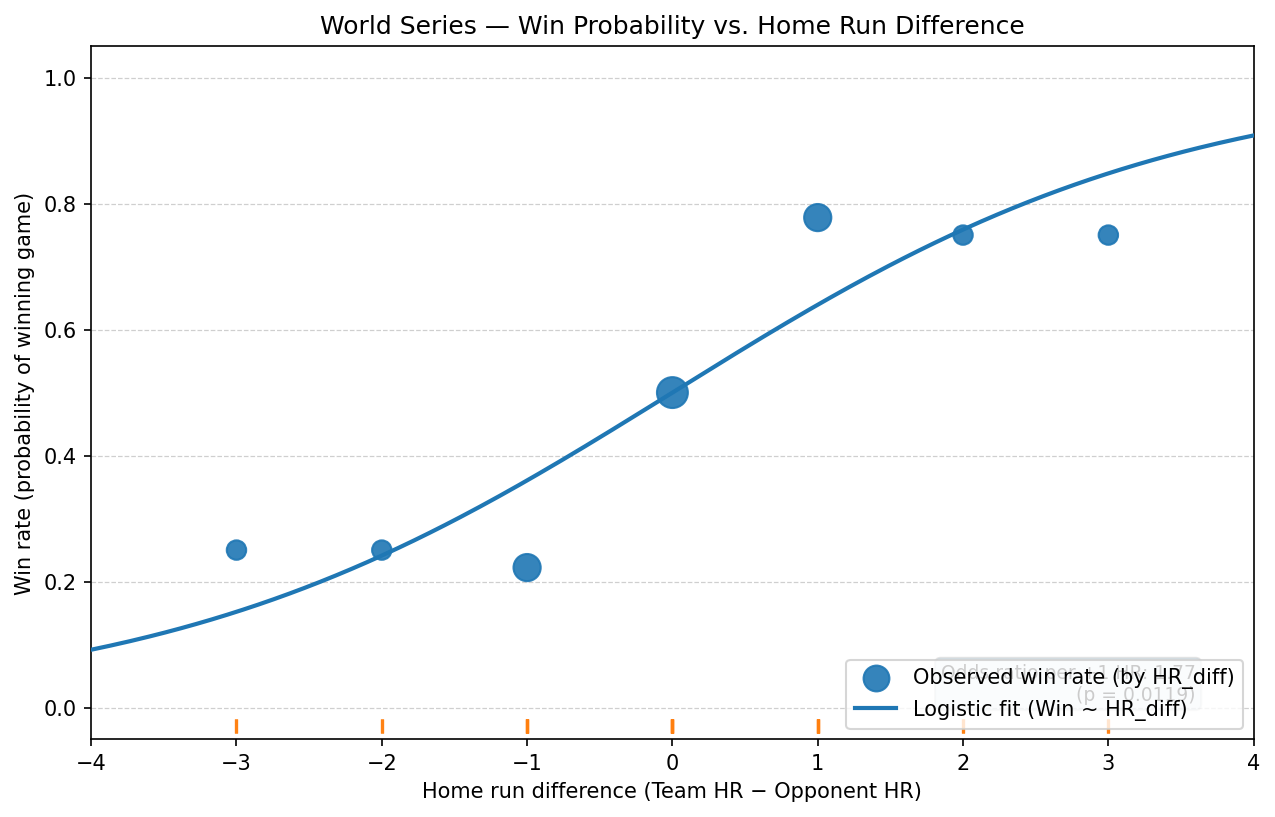

Saved summary CSV to: ws_hrdiff_winrate_summary.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
# 6) Hero visual: scatter (observed win rate) + logistic fit curve
# Create x values for smooth logistic curve
x_min, x_max = int(df["HR_diff"].min()), int(df["HR_diff"].max())
x_vals = np.linspace(x_min - 1, x_max + 1, 300)
logit_probs = 1 / (1 + np.exp(-(logit.params["const"] + logit.params["HR_diff"] * x_vals)))

plt.figure(figsize=(10,6), dpi=150)
# scatter observed win rates (size proportional to sample size)
sizes = (win_rate["N"] / win_rate["N"].max()) * 200 + 20
plt.scatter(win_rate["HR_diff"], win_rate["Win_Rate"], s=sizes, alpha=0.9, label="Observed win rate (by HR_diff)", zorder=3)
plt.plot(x_vals, logit_probs, linewidth=2, label="Logistic fit (Win ~ HR_diff)", zorder=4)

# Add a small jittered rug to show individual games (optional)
ys = df["Win"].values * 0.02  # tiny offset
plt.scatter(df["HR_diff"], df["Win"]*0.0 - 0.03, marker='|', s=40, alpha=0.6, zorder=2)

# Labels and title (editable)
plt.xlabel("Home run difference (Team HR − Opponent HR)")
plt.ylabel("Win rate (probability of winning game)")
plt.title("World Series — Win Probability vs. Home Run Difference")
plt.ylim(-0.05, 1.05)
plt.xlim(x_min-1, x_max+1)
plt.grid(axis='y', linestyle='--', linewidth=0.6, alpha=0.6)
plt.legend(loc="lower right")

# Annotate key stat on the plot
annot_text = f"Odds ratio per +1 HR: {odds_ratio:.2f}\n(p = {p_value:.3g})"
plt.annotate(annot_text, xy=(0.95, 0.05), xycoords='axes fraction',
             horizontalalignment='right', verticalalignment='bottom',
             fontsize=9, bbox=dict(boxstyle="round,pad=0.3", alpha=0.1))

# Save high-res PNG ready for LinkedIn (adjust DPI/figsize if you want wider)
out_png = "ws_hrdiff_winprob_hero.png"
plt.savefig(out_png, bbox_inches="tight")
print(f"\nSaved hero visual to: {out_png}")

plt.show()

# 7) Also save a small CSV summary (win rate by HR_diff)
summary_csv = "ws_hrdiff_winrate_summary.csv"
win_rate.to_csv(summary_csv, index=False)
print(f"Saved summary CSV to: {summary_csv}")

# 8) Provide files for download in Colab
files.download(out_png)
files.download(summary_csv)